# Cell type composition workspace

In [2]:
import numpy as np
import pandas as pd

import anndata as ad
import zarr
import scanpy as sc

import requests
import itertools
from collections import Counter
import os

from matplotlib import pyplot as plt
import seaborn as sns

import networkx as nx
import obonet

import altair as alt

## Loading data

We can retrieve the anndata either through the remote zarr storage, or by downloading the 'secondary_analysis.h5ad' locally. Both methods are shown below.

Regardless of method, we reshape the dataframe with cell counts in the same way.

In [27]:
#TODO: automatically detect what the current column name is from the currently used options in HuBMAP
#TODO: remove addictional predicted_id if not existing

def get_counts_from_adata_single(adata, index = 0, colname_predicted_id = 'predicted_CLID', colname_predicted_label = 'predicted_label'):
    if(colname_predicted_id == None): 
        df_adata = adata.obs[[colname_predicted_label]].value_counts().to_frame().reset_index().rename(columns={colname_predicted_label:'cell_type_label', 0:'cell_count'})
        df_adata['cell_type_CLID'] = df_adata['cell_type_label']
    else: 
        df_adata = adata.obs[[colname_predicted_id, colname_predicted_label]].value_counts().to_frame().reset_index().rename(columns={colname_predicted_id:'cell_type_CLID', colname_predicted_label:'cell_type_label', 0:'cell_count'})
    df_adata['sample_id'] = index
    df_adata['sample_n_cat'] = df_adata.shape[0]
    df_adata['sample_count'] = df_adata['cell_count'].sum()
    df_adata['cell_fraction'] = df_adata['cell_count'] / df_adata['sample_count']
    df_adata[['sample_id', 'cell_type_CLID', 'cell_type_label', 'cell_count', 'cell_fraction', 'sample_count', 'sample_n_cat']]
    return df_adata

### Remote zarr storage

In [65]:
#TODO: allow remote retrieval through hubmap-ids instead of uuids
#TODO: allow verification to retrieve datasets with protected access

def load_remote_anndata(uuids):

    def load_remote_anndata_zarr_single(zarr_url):
        '''
        For a given url, create anndata object with all columns of obs and X_pca and X_umap in remote storage.
        
        Parameters
        ----------
        zarr_url : string 
            Url of zarr storage

        Returns
        -------
            adata : anndata object
        '''
        root = zarr.open(zarr_url)
        obs_index = root.obs['_index']
        obs_df = pd.DataFrame(index = obs_index)
        obs_attrs = dict(root.obs.attrs)['column-order']

        for att in obs_attrs: 
            obs_df[att] = root.obs[att]

        obsm = {}
        
        for mapping in ['X_pca', 'X_umap']:
            obsm[mapping] = root.obsm[mapping]
        
        adata = ad.AnnData(obs=obs_df, obsm=obsm)
        return adata
    

    zarr_base = 'https://assets.hubmapconsortium.org/'
    zarr_ext = '/hubmap_ui/anndata-zarr/secondary_analysis.zarr'

    adata_dict = {}
    df_adata_dict = {}

    for index, id in enumerate(uuids): 
        zarr_url = zarr_base + id + zarr_ext
        adata_i = load_remote_anndata_zarr_single(zarr_url)
        adata_dict[id] = adata_i
        df_adata_i = get_counts_from_adata_single(adata_i, id, colname_predicted_id = None, colname_predicted_label = 'predicted.ASCT.celltype')
        df_adata_dict[id] = df_adata_i
    
    df_adata_comb = pd.concat(df_adata_dict).reset_index(drop=True)

    return adata_dict, df_adata_dict, df_adata_comb

Let's retrieve some data that is openly accessible.

In [14]:
uuids_open = ['d1e9f509063984326570cf603c5654f2', 'c1a0c043d0a986d71552091cc1b09742', 'f4b3c0e24e09e1e8c16f2e4e190a8cbb']
adata_dict, df_adata_dict, df_adata_comb = load_remote_anndata(uuids_open)

In [17]:
df_adata_comb.head()

,cell_type_label,cell_count,cell_type_CLID,sample_id,sample_n_cat,sample_count,cell_fraction
0,5,3972,5,d1e9f509063984326570cf603c5654f2,21,7897,0.502976
1,19,1546,19,d1e9f509063984326570cf603c5654f2,21,7897,0.195771
2,17,996,17,d1e9f509063984326570cf603c5654f2,21,7897,0.126124
3,3,589,3,d1e9f509063984326570cf603c5654f2,21,7897,0.074585
4,7,263,7,d1e9f509063984326570cf603c5654f2,21,7897,0.033304


### Local storage

In [60]:
def load_local_anndata(data_path, file_list = None):

    if file_list == None: 
        file_list = os.listdir(data_path)
    
    adata_dict = {}
    df_adata_dict = {}
    for index, file in enumerate(file_list): 
        adata_i = ad.read(data_path + file)
        adata_dict[file] = adata_i
        df_adata_i = get_counts_from_adata_single(adata_i, file)
        df_adata_dict[file] = df_adata_i

    df_adata_comb = pd.concat(df_adata_dict).reset_index(drop=True)
    
    return adata_dict, df_adata_dict, df_adata_comb

In [71]:
data_path = './../data/raw/h5ad/protected-access/'
adata_dict, df_adata_dict, df_adata_comb = load_local_anndata(data_path)

In [29]:
df_adata_comb.head()

,cell_type_CLID,cell_type_label,cell_count,sample_id,sample_n_cat,sample_count,cell_fraction
0,CL:0000057,kidney interstitial fibroblast,2677,HBM299.VDWT.444.h5ad,41,11994,0.223195
1,CL:4030013,kidney loop of Henle long descending thin limb...,1726,HBM299.VDWT.444.h5ad,41,11994,0.143905
2,CL:1001109,kidney loop of Henle cortical thick ascending ...,1578,HBM299.VDWT.444.h5ad,41,11994,0.131566
3,CL:4030012,kidney loop of Henle short descending thin lim...,1011,HBM299.VDWT.444.h5ad,41,11994,0.084292
4,CL:1000768,kidney connecting tubule epithelial cell,560,HBM299.VDWT.444.h5ad,41,11994,0.046690


It's also nice to be able to generate vectors of the counts for each sample.

In [80]:
def get_embeddings(df_adata_comb):
    df_embs = df_adata_comb.pivot(index = 'sample_id', columns = 'cell_type_CLID')['cell_count'].fillna(0)
    df_embs_f = df_embs.div(df_embs.sum(axis=1), axis=0)

    return df_embs, df_embs_f

## Examining one sample

In [67]:
data_path = './../data/raw/h5ad/protected-access/'
file_list = ['HBM299.VDWT.444.h5ad']
adata_dict_HBM299, df_adata_dict_HBM299, df_HBM299 = load_local_anndata(data_path, file_list = file_list)

c:\Users\lcsmi\Documents\GehlenborgLab\SpatialOmics\CellTypes\.venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


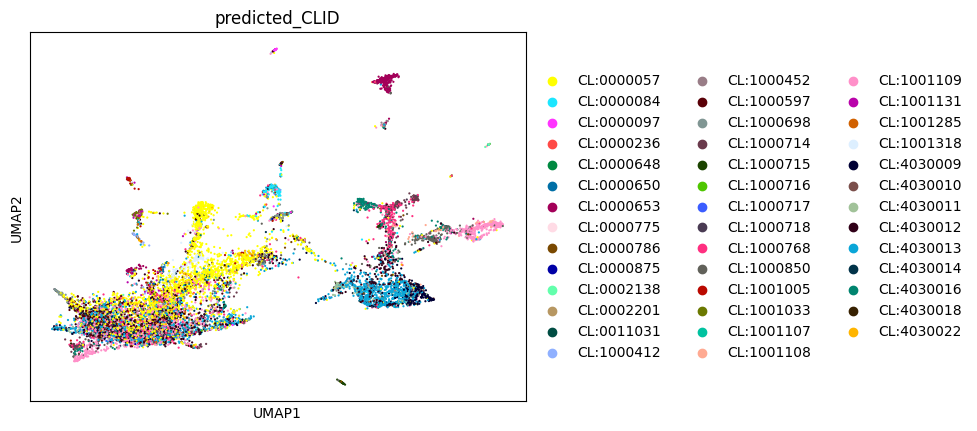

In [64]:
sc.pl.umap(adata_dict_HBM299[file_list[0]], color = "predicted_CLID")

We can display the composition of cell types in various ways:

In [66]:
g1 = alt.Chart(df_HBM299).mark_bar().encode(
    x = alt.X('sample_id:O', axis = alt.Axis(title = 'ID')),
    y = alt.Y('cell_fraction:Q', axis = alt.Axis(title ='Fraction'), scale=alt.Scale(domain=[0, 1])),
    color = alt.Color('cell_type_CLID:N', sort = 'y'),
    order = alt.Order('cell_fraction', sort = 'descending'),
    tooltip=['cell_type_CLID', 'cell_type_label', 'cell_fraction']
).properties(
    title = str(1) + ' cells; ' + str(1) + ' types of cells'
).interactive()

g1.show()

Displaying chart at http://localhost:52765/


Since there are many very small fractions, we might want to collapse those together.

In [69]:
combine_other = True
threshold = 0.01

def combine_other_fractions(df, threshold):
    keep = df[df['cell_fraction'] >= threshold]
    keep['cell_fraction_sort'] = keep['cell_fraction']
    removed = df[df['cell_fraction'] < threshold]
    
    other = removed.groupby(['sample_id']).agg({'cell_type_CLID':'first', 'cell_type_label':'first', 'cell_count': 'sum', 'sample_id': 'first', 'sample_n_cat': 'first', 'sample_count': 'first', 'cell_fraction': 'sum'})
    other['cell_type_CLID'] = 'other'
    other['cell_type_label'] = 'other'
    other['cell_fraction_sort'] = 0
    other = other.reset_index(drop = True)
    
    comb = pd.concat([keep, other])

    return comb

if combine_other:
    df_HBM299 = combine_other_fractions(df_HBM299, threshold)

C:\Users\lcsmi\AppData\Local\Temp\ipykernel_19092\1524613064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep['cell_fraction_sort'] = keep['cell_fraction']


With only one sample, there is no need to stack the bars.

In [76]:
bars= alt.Chart(df_HBM299).mark_bar().encode(
    x = alt.X('cell_fraction:Q', axis = alt.Axis(title ='Fraction'), scale=alt.Scale(domain=[0, 1])),
    y = alt.Y('cell_type_CLID:N', sort = {'field': 'cell_fraction_sort', 'order': 'descending'}, axis = alt.Axis(title = 'ID')),
    tooltip=['cell_type_CLID', 'cell_type_label', 'cell_fraction']
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3 
).encode(
    text=alt.Text('cell_fraction:Q', format = ".0000")
)

g2 = (bars + text).properties()

g2.show()

Displaying chart at http://localhost:52765/


In [77]:
#TODO: add support for hovering over 'other' and seeing composition

## Examining a few samples

In [73]:
data_path = './../data/raw/h5ad/protected-access/'
adata_dict_few, df_adata_dict_few, df_adata_comb_few = load_local_anndata(data_path)

In [75]:
## stacked bar chart

g1 = alt.Chart(df_adata_comb_few).mark_bar().encode(
    x = alt.X('sample_id:O', axis = alt.Axis(title = "ID")),
    y = alt.Y('cell_fraction:Q', axis = alt.Axis(title ="Fraction"), scale=alt.Scale(domain=[0, 1])),#, sort = {'aggregate': [{'field': 'cell_fraction', 'op':'sum'}], 'order':'descending'}),
    color = alt.Color('cell_type_CLID:N', sort = 'y'),
    tooltip=['sample_id',  'cell_fraction', 'cell_type_CLID', 'cell_type_label']
#).transform_aggregate(
 #   comb_frac = 'sum(cell_fraction)'
).properties(
    #width = 1000
).interactive() 

g1.show()

Displaying chart at http://localhost:52765/


In [ ]:
## stacked bar chart

selection = alt.selection_multi(fields=['cell_type_CLID'], bind = 'legend')

g1 = alt.Chart(df_adata_comb).mark_bar().encode(
    x = alt.X('sample_id:O', axis = alt.Axis(title = "ID")),
    y = alt.Y('cell_fraction:Q', axis = alt.Axis(title ="Fraction"), scale=alt.Scale(domain=[0, 1])),#, sort = {'aggregate': [{'field': 'cell_fraction', 'op':'sum'}], 'order':'descending'}),
    color = alt.Color('cell_type_CLID:N', sort = 'y'),
    opacity = alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=['sample_id',  'cell_fraction', 'cell_type_CLID', 'cell_type_label']
#).transform_aggregate(
 #   comb_frac = 'sum(cell_fraction)'
).add_selection(
    selection
)

g1.show()

## Examining many samples

In [82]:
#TODO: add sample clustering to altair heatmap

def order_df_heatmap(df_embs_f): 
    # Clustermap for rows only
    g = sns.clustermap(df_embs_f, col_cluster=False, cmap="magma")

    # Get the reodered indices
    reordered_indices = g.dendrogram_row.reordered_ind

    # Create a dictionary
    reordering_dict = pd.Series(reordered_indices, index=df_embs_f.index.values).to_dict()

    return(reordering_dict)

df_embs, df_embs_f = get_embeddings(df_adata_comb)
#reordering_dict = order_df_heatmap(df_embs_f)

In [83]:
#TODO: add altair network to altair heatmap

In [79]:
g = alt.Chart(df_adata_comb).mark_rect().encode(

    x = alt.X('cell_type_CLID:O', axis = alt.Axis(title = 'Cell type')),
    y = alt.Y('sample_id:O', axis = alt.Axis(title = 'Sample')),
    color = alt.Color('cell_fraction:Q', scale=alt.Scale(domain=[0, 1])),
    tooltip=['cell_type_CLID',  'cell_type_label', 'sample_id', 'cell_fraction']
).properties(
).interactive()

g.show()

Displaying chart at http://localhost:52765/


## Drawing networkx in altair

### Furthermore, we want to leverage the cell ontology for relations between cell types.

In [134]:
class ontologyGraph:
    '''
    A class used to instantiate networks of the cell ontology.

    Attributes
    ----------
    G : networkx Graph
    depths_graph : dict
    shortest_paths : dict
    id_to_name : dict
    name_to_id : dict
    '''
    def __init__(self, G, root = 'CL:0000000'):
        self.G = G
        self.depths_graph = nx.shortest_path_length(G, target=root)
        self.shortest_paths = nx.shortest_path(G, target=root)

        ## update G to have the depths of graph in case these were not yet present
        nx.set_node_attributes(self.G, self.depths_graph, "depth")

        self.id_to_name = {id_: data.get('name') for id_, data in self.G.nodes(data=True)}
        self.name_to_id = {data['name']: id_ for id_, data in self.G.nodes(data=True) if 'name' in data}


class ontologyGraphWithData: 
    '''
    A class used to create and store various networks for cell label nodes in a given dataframe

    Attributes
    ----------
    Graphs : dict
    df : pandas dataframe
    nodes_df : list of nodes
    nodes_plus_df : list of nodes
    collapsed : Boolean (default False)

    Methods
    -------
    '''
    def __init__(self, df):
        self.Graphs = {"full": None,
                       "tree": None,
                       "subs": None,
                       "collapsed": None
                       }
        self.df = df
        self.nodes_df = None
        self.nodes_plus_df = None
        self.collapsed = False


    def load_values(self):
        self.Graphs['full'] = ontologyGraph(self.load_onto())
        self.Graphs['tree'] = ontologyGraph(self.retrieve_tree())
        res = self.retrieve_nodes_df()
        self.nodes_df = res[0]
        self.nodes_plus_df = res[1] 
        self.Graphs['subs'] = ontologyGraph(res[2])

    
    def load_onto(self):
        G = obonet.read_obo("http://purl.obolibrary.org/obo/cl/cl-basic.obo")

        ## remove 1 weird node
        smallest_cc = min(nx.weakly_connected_components(G), key=len)
        node_removed = list(smallest_cc)[0]
        G.remove_node(node_removed)

        return G
    

    def retrieve_tree(self, root="CL:0000000"):
        ## remove the edges that aren't "is_a"
        e_list = [e for e in self.Graphs['full'].G.edges(keys=True) if e[2] == "is_a"]

        G_t = self.Graphs['full'].G.edge_subgraph(e_list).copy()
        G_t_paths = nx.shortest_path(G_t, target=root)

        edges_tree_set = set()
        for node, path in G_t_paths.items(): 
            for i in range(len(path)-1):
                edge = (path[i], path[i+1], "is_a")
                edges_tree_set.add(edge)
        G_tree = G_t.edge_subgraph(edges_tree_set).copy()

        return G_tree
    

    def retrieve_nodes_df(self, current_ontology_column="cell_type_CLID"):
        nodes_df = self.df[current_ontology_column].unique()
        nodes_plus_df = set(nodes_df)
        nodes_plus_df.add("CL:0000000")
       
        all_in_network = True
        if all_in_network: 
            for node in nodes_df: 
                path_to_root_i = self.Graphs['tree'].shortest_paths[node]
                for node in path_to_root_i: 
                    nodes_plus_df.add(node)

        #fix that this is tree
        else:   
            iter_tup_nodes_df = itertools.combinations(nodes_df, 2)
            iter_lca_nodes_df = nx.tree_all_pairs_lowest_common_ancestor(self.Graphs['tree'].G.reverse(), pairs = iter_tup_nodes_df)
            for nodes, lca in iter_lca_nodes_df: 
                nodes_plus_df.add(lca)
            
        G_sub = self.Graphs['tree'].G.subgraph(nodes_plus_df).copy()

        return(nodes_df, nodes_plus_df, G_sub)
    

    def draw_tree(self, which = 'subs'): 
        ## fiend positions for dendrogram-like style

        ## determine amount of nodes per level
        ## ..
        def hierarchy_pos(G, root='CL:0000000', width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
            '''
            Adapted from Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
            Licensed under Creative Commons Attribution-Share Alike 
            If the graph is a tree this will return the positions to plot this in a 
            hierarchical layout.
            '''
            
            if not nx.is_tree(self.Graphs[which].G):
                raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

            if pos is None:
                pos = {root:(xcenter,vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            children = list(G.neighbors(root))
            if not isinstance(G, nx.DiGraph) and parent is not None:
                children.remove(parent)  
            if len(children)!=0:
                dx = width/len(children) 
                nextx = xcenter - width/2 - dx/2
                for child in children:
                    nextx += dx
                    pos = hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                        vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                        pos=pos, parent = root)
            return pos          
        
        graph = self.Graphs[which].G

        pos = hierarchy_pos(graph.reverse(), root='CL:0000000')   
        nx.draw(graph, pos=pos, node_size = 40, with_labels = False, arrows = False, node_color = 'black')

        labels = {}
        for node in graph.nodes(): 
            if node in self.nodes_df: 
                labels[node] = node
        nx.draw_networkx_labels(self.Graphs[which].G, pos=pos, labels = labels, font_size = 8, verticalalignment = 'top', horizontalalignment='right')
        nx.draw_networkx_nodes(self.Graphs[which].G, pos=pos, nodelist = self.nodes_df, node_size = 40, node_color = 'red') 
        
        return        

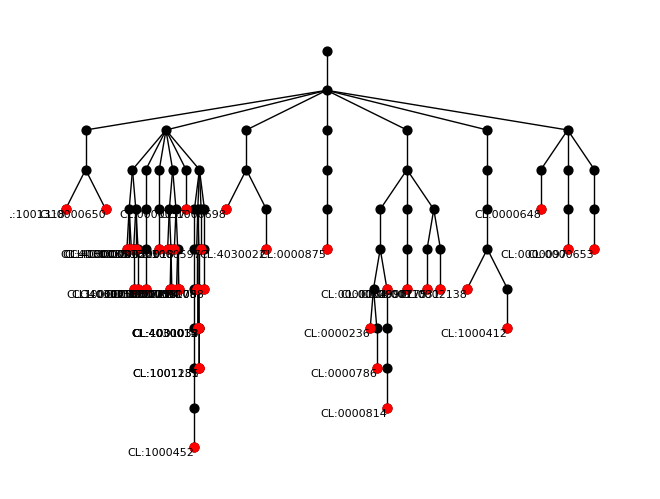

In [135]:
g = ontologyGraphWithData(df_adata_comb_few)
g.load_values()
g.draw_tree()

In [ ]:
#TODO: fix layout with pos
#TODO: add graph with altair
#TODO: make graph interactively linked (hover, select) with heatmap / bars